<a href="https://colab.research.google.com/github/2kunal6/UniBonn/blob/master/cuda_lab/2/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
datasets loaded
Label: tensor(0)


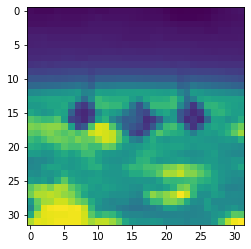

Running on the GPU
epoch: 0, loss: 2.3555338382720947
epoch: 1, loss: 3.050051212310791
[[ 17 200  12   3   0 591  28   3   9 137]
 [  2 493  12  10   5 153  33   5   3 284]
 [  3 147  40  13   1 638  73   3   0  82]
 [  2 159  24  45   3 554  80   3   3 127]
 [  2 131  22   9  12 627  70   3   1 123]
 [  2 112  33  29   5 658  74   5   0  82]
 [  1 242   4  18   3 433 143   3   0 153]
 [  1 159  27  14   5 499  43  25   2 225]
 [  7 396  14   5   0 365  24   4   9 176]
 [  4 327  14   3   0 125  31   2   3 491]]
Accuracy of the network on the 10000 test images: 19.33


In [10]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

np.random.seed(1)

transform_list = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
            #transforms.Normalize([0.5,],[0.5,])
        ])
train = torch.utils.data.DataLoader(
    datasets.CIFAR10("./", train=True, transform=transform_list, download=True), batch_size = 32, shuffle = True
)

test = torch.utils.data.DataLoader(
    datasets.CIFAR10("./", train=False, transform=transform_list, download=True), batch_size = 32, shuffle = True
)

print("datasets loaded")

IMG_SIZE = 32*32

for data in train:
  X, y = data[0][0], data[1][0]
  plt.imshow(X.view(32, 32))
  print("Label: " + str(y))
  plt.show()
  break

class LogisticRegression(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, x):
    return self.linear(x)

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

model = LogisticRegression(IMG_SIZE, 10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



for epoch in range(2):
  for data in train:
    X, y = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    output = model(X.view(-1, IMG_SIZE))
    loss = F.cross_entropy(output, y)
    loss.backward()
    optimizer.step()
  print(f'epoch: {epoch}, loss: {loss}')

def test_perform():
  total = 0
  correct = 0

  y_true = []
  y_pred = []
  with torch.no_grad():
    for data in test:
      X, y = data[0].to(device), data[1].to(device)

      output = model(X.view(-1, IMG_SIZE))
      _, predicted = torch.max(output, 1)

      total += y.size(0)
      correct += (predicted == y).sum().item()

      y_pred.extend(predicted.tolist())
      y_true.extend(y.tolist())

    accuracy = 100 * correct / total
    return accuracy, y_true, y_pred
    
accuracy, y_true, y_pred = test_perform()

print(confusion_matrix(y_true, y_pred))
print(f'Accuracy of the network on the 10000 test images: {accuracy}')